#RAG Model



## Install required dependencies

In [1]:
!pip install -q transformers sentence-transformers faiss-cpu langchain_community chromadb datasets accelerate bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.9 MB/s eta 

In [2]:
!pip install pytesseract Pillow opencv-python

In [3]:
# Essential imports
import os
import time
import json
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import List, Dict, Any, Tuple, Optional, Union
from google.colab import files

# For visualization
import plotly.express as px
import plotly.graph_objects as go

# For OCR and image processing
import cv2
from PIL import Image
import io
import pytesseract  # Now this should work after installation

##Set up the embedding model and language model


In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain_community.llms import HuggingFacePipeline
from langchain_community.embeddings import HuggingFaceEmbeddings

# Use a smaller model for embeddings (runs locally)
embeddings = HuggingFaceEmbeddings(
    model_name="all-MiniLM-L6-v2",
    model_kwargs={'device': 'cuda' if torch.cuda.is_available() else 'cpu'}
)

# Set up a smaller LLM that can run locally
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # Smaller model that runs on CPU
# Alternative models: "google/flan-t5-small", "facebook/opt-125m", or "distilgpt2"

# Load model with lower precision to save memory
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    load_in_8bit=True  # For even smaller memory footprint
)

# Create a text generation pipeline
text_generation = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.7,
    top_p=0.95,
    repetition_penalty=1.15
)

# Create LangChain wrapper
llm = HuggingFacePipeline(pipeline=text_generation)

print("Models loaded successfully!")

<ipython-input-4-8015407a26d7>:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cuda:0


Models loaded successfully!


<ipython-input-4-8015407a26d7>:37: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=text_generation)


In [5]:
from langchain_community.vectorstores import FAISS, Chroma
import os

class SimpleVectorDatabase:
    """Simple vector database using FAISS"""

    def __init__(self, embeddings_model):
        self.embeddings = embeddings_model
        self.learning_materials_db = None
        self.flashcards = []

    def add_documents(self, documents):
        """Add documents to the vector store"""
        if not documents:
            return []

        texts = [doc["content"] for doc in documents]
        metadatas = [{"title": doc["title"], "topic": doc["topic"], "difficulty": doc["difficulty"]} for doc in documents]

        # Create or update vector database
        if self.learning_materials_db is None:
            self.learning_materials_db = FAISS.from_texts(texts, self.embeddings, metadatas=metadatas)
        else:
            self.learning_materials_db.add_texts(texts, metadatas=metadatas)

        # Return added documents with IDs
        return [{"id": f"doc_{i}", **doc} for i, doc in enumerate(documents)]

    def search(self, query, top_k=3):
        """Search for relevant documents"""
        if self.learning_materials_db is None:
            return []

        results = self.learning_materials_db.similarity_search(query, k=top_k)
        return [{"content": doc.page_content, **doc.metadata} for doc in results]

    def add_flashcard(self, flashcard):
        """Add a flashcard to the database"""
        flashcard_id = f"fc_{len(self.flashcards)}"
        flashcard["id"] = flashcard_id
        self.flashcards.append(flashcard)
        return flashcard_id

    def get_flashcards(self, topic=None, difficulty=None):
        """Get flashcards, optionally filtered by topic or difficulty"""
        results = self.flashcards

        if topic:
            results = [fc for fc in results if fc.get("topic") == topic]

        if difficulty:
            results = [fc for fc in results if fc.get("difficulty") == difficulty]

        return results

    def get_due_flashcards(self):
        """Get flashcards that are due for review"""
        now = datetime.now()
        return [fc for fc in self.flashcards if fc.get("nextReviewDate") and fc.get("nextReviewDate") <= now]

    def update_flashcard(self, flashcard_id, updates):
        """Update a flashcard in the database"""
        for i, fc in enumerate(self.flashcards):
            if fc["id"] == flashcard_id:
                self.flashcards[i].update(updates)
                return True
        return False

# Create database instance
vector_db = SimpleVectorDatabase(embeddings)

##PDF Processing with PyPDF and Local Extraction

In [6]:
# Install pdf processing library if needed
!pip install -q PyPDF2

import PyPDF2
from io import BytesIO
import re
from langchain.text_splitter import RecursiveCharacterTextSplitter

class DocumentProcessor:
    """Process documents and add to vector database"""

    def __init__(self, vector_db):
        self.db = vector_db
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len,
        )

    def extract_text_from_pdf(self, file_path_or_content):
        """Extract text from PDF files"""
        try:
            if isinstance(file_path_or_content, bytes):
                # Process bytes content
                pdf_file = BytesIO(file_path_or_content)
            else:
                # Process file path
                pdf_file = open(file_path_or_content, 'rb')

            pdf_reader = PyPDF2.PdfReader(pdf_file)
            text = ""

            # Extract text from all pages
            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                text += page.extract_text() + "\n\n"

            if not isinstance(file_path_or_content, bytes):
                pdf_file.close()

            return text

        except Exception as e:
            print(f"Error extracting text from PDF: {e}")
            return ""

    def process_document(self, file_path, file_content=None, title=None, topic=None):
        """Process document and add to vector database"""
        if file_content:
            text = self.extract_text_from_pdf(file_content)
            if not title:
                title = "Uploaded Document"
        else:
            # Process from file path
            _, file_extension = os.path.splitext(file_path)
            file_extension = file_extension.lower()

            if file_extension == '.pdf':
                text = self.extract_text_from_pdf(file_path)
            elif file_extension in ['.txt', '.md']:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read()
            else:
                raise ValueError(f"Unsupported file extension: {file_extension}")

            # Get title from filename if not provided
            if not title:
                title = os.path.basename(file_path).replace(file_extension, '')

        # Split text into chunks
        chunks = self.text_splitter.split_text(text)

        # Store in database
        learning_materials = []
        for i, chunk in enumerate(chunks):
            material = {
                "title": f"{title} - Section {i+1}",
                "content": chunk,
                "topic": topic or self._extract_topic(chunk),
                "difficulty": self._estimate_difficulty(chunk)
            }

            learning_materials.append(material)

        # Add all materials to vector database
        return self.db.add_documents(learning_materials)

    def _extract_topic(self, text):
        """Extract topic from text using heuristic approach"""
        topic_keywords = {
            "python": "Python Programming",
            "machine learning": "Machine Learning",
            "deep learning": "Deep Learning",
            "neural network": "Deep Learning",
            "nlp": "Natural Language Processing",
            "natural language": "Natural Language Processing",
            "algorithm": "Algorithms",
            "data structure": "Data Structures"
        }

        text_lower = text.lower()
        for keyword, topic in topic_keywords.items():
            if keyword in text_lower:
                return topic

        return "General"

    def _estimate_difficulty(self, text):
        """Estimate difficulty of text (1-5)"""
        # Count complex words (words longer than 7 characters)
        words = re.findall(r'\b\w+\b', text)
        complex_words = [w for w in words if len(w) > 7]
        complex_ratio = len(complex_words) / len(words) if words else 0

        # Count sentence length
        sentences = re.split(r'[.!?]+', text)
        avg_sentence_length = sum(len(re.findall(r'\b\w+\b', s)) for s in sentences) / len(sentences) if sentences else 0

        # Calculate readability score (simplified)
        difficulty = 1 + int(min(4, (complex_ratio * 10 + avg_sentence_length / 5) / 2))

        return difficulty

# Initialize document processor
doc_processor = DocumentProcessor(vector_db)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.9 MB/s eta 0:00:00


##Create a locally-run Question Generator

In [7]:
class LocalQuestionGenerator:
    """
    Generate questions based on learning materials using a local LLM
    """
    def __init__(self, vector_db, llm):
        self.db = vector_db
        self.llm = llm

    def generate_questions(self, topic=None, difficulty_level=2, num_questions=3, bloom_level=None):
        """Generate questions with a local model"""
        # If no specific Bloom's level provided, determine from difficulty
        if bloom_level is None:
            bloom_level = BloomsTaxonomy.get_level_for_difficulty(difficulty_level)

        # Retrieve relevant context
        query = topic if topic else "general knowledge"
        contexts = self.db.search(query, top_k=3)

        if not contexts:
            print("No relevant contexts found. Please add some learning materials first.")
            return []

        # Format context for LLM prompt
        context_text = "\n\n".join([ctx["content"] for ctx in contexts])

        # Get appropriate verbs for the Bloom's level
        level_info = BloomsTaxonomy.LEVELS[bloom_level]
        verbs = level_info["verbs"]

        # Create a simpler, more direct prompt for smaller models
        prompt = f"""
You are a reasoning-based quiz generator. Given the following text, create a question and answer that tests reasoning, not just recall.

TEXT:
{context_text[:2000]}  # Limit context size for smaller models

REASONING:

INSTRUCTIONS:
- Focus on {bloom_level} level questions using verbs like: {', '.join(verbs[:3])}
- Each question should test {level_info['description']}
- For each question, provide both the question and answer
- Make questions clear and specific
- Format: Q1: [question] A1: [answer]

QUESTIONS AND ANSWERS:
"""

        try:
            # Generate text with the local model
            response = self.llm.invoke(prompt)

            # Parse the response to extract questions and answers
            qa_pairs = self._parse_questions_answers(response)

            # Create flashcards from questions
            flashcards = []
            for q, a in qa_pairs:
                if len(q) > 10 and len(a) > 10:  # Basic validation
                    flashcard = {
                        "question": q,
                        "answer": a,
                        "topic": topic or "General",
                        "difficulty": difficulty_level,
                        "bloomLevel": bloom_level,
                        "easinessFactor": 2.5,
                        "interval": 0,
                        "repetitions": 0,
                        "nextReviewDate": datetime.now(),
                        "lastReviewDate": None
                    }

                    # Add to database
                    flashcard_id = self.db.add_flashcard(flashcard)
                    flashcards.append({
                        "id": flashcard_id,
                        **flashcard
                    })

            return flashcards

        except Exception as e:
            print(f"Error generating questions: {e}")
            return []

    def _parse_questions_answers(self, text):
        """Parse questions and answers from model output"""
        qa_pairs = []

        # Try to match question-answer pattern using different patterns
        # Pattern 1: Q1: ... A1: ...
        pattern1 = r"Q\d+:\s*(.*?)\s*A\d+:\s*(.*?)(?=Q\d+:|$)"
        matches = re.findall(pattern1, text, re.DOTALL)
        if matches:
            return [(q.strip(), a.strip()) for q, a in matches]

        # Pattern 2: Question: ... Answer: ...
        pattern2 = r"Question(?:\s\d+)?:\s*(.*?)\s*Answer(?:\s\d+)?:\s*(.*?)(?=Question(?:\s\d+)?:|$)"
        matches = re.findall(pattern2, text, re.DOTALL)
        if matches:
            return [(q.strip(), a.strip()) for q, a in matches]

        # Pattern 3: 1. Question ... Answer: ...
        pattern3 = r"(?:\d+\.\s*)(.*?)\s*Answer:\s*(.*?)(?=\d+\.|$)"
        matches = re.findall(pattern3, text, re.DOTALL)
        if matches:
            return [(q.strip(), a.strip()) for q, a in matches]

        # Fallback: Just split by lines and pair them up
        lines = [line.strip() for line in text.split('\n') if line.strip()]
        for i in range(0, len(lines)-1, 2):
            if i+1 < len(lines):
                qa_pairs.append((lines[i], lines[i+1]))

        return qa_pairs

##File Upload in Google Colab

In [8]:
from google.colab import files

def upload_and_process_pdf():
    """Upload and process PDF in Google Colab"""
    print("Please upload one or more PDF files...")
    uploaded = files.upload()

    all_materials = []

    for filename, content in uploaded.items():
        print(f"Processing {filename}...")

        # Get title from filename
        title = filename.rsplit('.', 1)[0]

        # Ask for topic
        topic = input(f"Enter topic for {filename} (or leave blank for auto-detection): ")
        if not topic:
            topic = None

        # Process the document
        materials = doc_processor.process_document(
            file_path=filename,
            file_content=content,
            title=title,
            topic=topic
        )

        all_materials.extend(materials)

        print(f"Added {len(materials)} chunks from {filename} to the database")

    return all_materials

##Implement SM2 Spaced Repetition Algorithm

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from typing import Tuple

class SM2Algorithm:
    """
    Implementation of the SuperMemo 2 (SM2) spaced repetition algorithm
    """

    @staticmethod
    def calculate_next_review(quality: int, prev_easiness: float,
                             prev_interval: int, prev_repetitions: int) -> Tuple[float, int, int, datetime]:
        """
        Calculate the next review date based on the SM2 algorithm

        Args:
            quality: Rating of recall quality (0-5)
                    0 = complete blackout
                    1 = incorrect response; the correct one remembered
                    2 = incorrect response; correct one seemed familiar
                    3 = correct response with difficulty
                    4 = correct response after hesitation
                    5 = perfect response
            prev_easiness: Previous easiness factor
            prev_interval: Previous interval (in days)
            prev_repetitions: Previous number of repetitions

        Returns:
            Tuple of (new_easiness, new_interval, new_repetitions, next_review_date)
        """
        # Default easiness factor if not provided
        if prev_easiness is None or prev_easiness < 1.3:
            prev_easiness = 2.5

        # Calculate new easiness factor
        new_easiness = prev_easiness + (0.1 - (5 - quality) * (0.08 + (5 - quality) * 0.02))

        # Ensure easiness doesn't go below 1.3
        if new_easiness < 1.3:
            new_easiness = 1.3

        # Reset repetitions if quality < 3 (incorrect recall)
        if quality < 3:
            new_repetitions = 0
            new_interval = 1
        else:
            # Increment repetitions counter
            new_repetitions = prev_repetitions + 1

            # Calculate new interval
            if new_repetitions == 1:
                new_interval = 1
            elif new_repetitions == 2:
                new_interval = 6
            else:
                new_interval = round(prev_interval * new_easiness)

        # Calculate next review date
        next_review_date = datetime.now() + timedelta(days=new_interval)

        return new_easiness, new_interval, new_repetitions, next_review_date

    @staticmethod
    def visualize_schedule(initial_easiness=2.5, days=60):
        """Visualize spaced repetition schedule over time"""
        # Define quality scenarios
        quality_scenarios = {
            "Perfect recall (5)": 5,
            "Good recall (4)": 4,
            "Moderate recall (3)": 3,
            "Difficult recall (2)": 2
        }

        # Track intervals for each scenario
        scenario_intervals = {}

        # Run simulations
        for scenario_name, quality in quality_scenarios.items():
            intervals = []
            review_dates = []

            # Initialize
            easiness = initial_easiness
            interval = 0
            repetitions = 0
            review_date = datetime.now()

            # Simulate reviews
            total_days = 0
            while total_days < days:
                # Calculate next review
                easiness, interval, repetitions, review_date = SM2Algorithm.calculate_next_review(
                    quality, easiness, interval, repetitions
                )

                # Add to tracking
                intervals.append(interval)
                review_dates.append(review_date)

                # Update total days
                total_days += interval

            scenario_intervals[scenario_name] = intervals

        # Visualization
        fig = plt.figure(figsize=(12, 6))

        # Plot interval growth over time
        ax1 = fig.add_subplot(111)

        for scenario, intervals in scenario_intervals.items():
            # Calculate cumulative days for x-axis
            cumulative_days = np.cumsum(intervals)

            # Only plot points that fall within our day limit
            valid_indices = cumulative_days <= days
            cumulative_days = cumulative_days[valid_indices]
            plotted_intervals = np.array(intervals)[valid_indices]

            # Plot
            ax1.plot(cumulative_days, plotted_intervals, 'o-', label=scenario, alpha=0.7)

        ax1.set_xlabel('Cumulative Days', fontsize=12)
        ax1.set_ylabel('Review Interval (days)', fontsize=12)
        ax1.set_title('Spaced Repetition Intervals Over Time', fontsize=14)
        ax1.grid(True, linestyle='--', alpha=0.7)
        ax1.legend()

        plt.tight_layout()
        plt.show()

## Bloom's Taxonomy for Adaptive Difficulty

In [10]:


import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class BloomsTaxonomy:
    """
    Implementation of Bloom's Taxonomy for question difficulty
    """
    LEVELS = {
        "knowledge": {
            "description": "Recall of facts, terms, basic concepts",
            "difficulty": 1,
            "verbs": ["define", "describe", "identify", "list", "name", "recall", "recognize", "state"],
            "question_templates": [
                "What is the definition of {concept}?",
                "List the key characteristics of {concept}.",
                "Identify the components of {concept}.",
                "Recall the main features of {concept}."
            ]
        },
        "comprehension": {
            "description": "Understanding of facts, comparing, organizing, interpreting",
            "difficulty": 2,
            "verbs": ["classify", "compare", "contrast", "explain", "illustrate", "summarize", "translate"],
            "question_templates": [
                "Explain in your own words what {concept} means.",
                "Compare {concept1} and {concept2}.",
                "Summarize the main points about {concept}.",
                "Illustrate how {concept} works with an example."
            ]
        },
        "application": {
            "description": "Use of knowledge in new situations, problem-solving",
            "difficulty": 3,
            "verbs": ["apply", "calculate", "demonstrate", "implement", "solve", "use"],
            "question_templates": [
                "How would you apply {concept} to solve this problem: {problem}?",
                "Demonstrate how {concept} can be used in {context}.",
                "Solve this problem using {concept}: {problem}.",
                "Calculate the {outcome} using the principles of {concept}."
            ]
        },
        "analysis": {
            "description": "Breaking information into parts, finding patterns",
            "difficulty": 4,
            "verbs": ["analyze", "categorize", "differentiate", "examine", "investigate", "test"],
            "question_templates": [
                "Analyze the relationship between {concept1} and {concept2}.",
                "What are the underlying assumptions of {concept}?",
                "Differentiate between the components of {concept}.",
                "Examine the structure of {concept} and identify its key elements."
            ]
        },
        "synthesis": {
            "description": "Putting information together in a new way",
            "difficulty": 5,
            "verbs": ["construct", "create", "design", "develop", "formulate", "integrate"],
            "question_templates": [
                "Design a new approach that incorporates {concept}.",
                "Formulate a theory that explains {phenomenon} using {concept}.",
                "Create a solution for {problem} based on {concept}.",
                "Integrate {concept1} and {concept2} to develop a comprehensive framework."
            ]
        },
        "evaluation": {
            "description": "Making judgments based on criteria",
            "difficulty": 5,
            "verbs": ["appraise", "critique", "evaluate", "judge", "justify", "validate"],
            "question_templates": [
                "Evaluate the effectiveness of {concept} in addressing {problem}.",
                "Critique the approach used in {context} based on {criteria}.",
                "Justify the use of {concept} in {situation}.",
                "What are the strengths and weaknesses of {concept}?"
            ]
        }
    }

    @staticmethod
    def get_level_for_difficulty(difficulty):
        """Get appropriate Bloom's level for a target difficulty"""
        if difficulty <= 1:
            return "knowledge"
        elif difficulty == 2:
            return "comprehension"
        elif difficulty == 3:
            return "application"
        elif difficulty == 4:
            return "analysis"
        else:
            # Randomize between synthesis and evaluation for difficulty 5
            return random.choice(["synthesis", "evaluation"])

    @staticmethod
    def visualize_taxonomy():
        """Create a visualization of Bloom's Taxonomy levels"""
        # Extract data from the LEVELS dictionary
        levels = list(BloomsTaxonomy.LEVELS.keys())
        descriptions = [BloomsTaxonomy.LEVELS[level]["description"] for level in levels]
        difficulties = [BloomsTaxonomy.LEVELS[level]["difficulty"] for level in levels]

        # Capitalize level names for display
        levels = [level.capitalize() for level in levels]

        # Create a DataFrame for easier manipulation
        df = pd.DataFrame({
            'Level': levels,
            'Description': descriptions,
            'Difficulty': difficulties
        })

        # Sort by difficulty
        df = df.sort_values('Difficulty')

        # Create a figure for visualization
        fig, ax = plt.subplots(figsize=(12, 8))

        # Pyramid visualization of Bloom's Taxonomy
        bars = ax.barh(df['Level'], df['Difficulty'], color=sns.color_palette("viridis", len(df)))
        ax.set_title('Bloom\'s Taxonomy - Cognitive Complexity', fontsize=14)
        ax.set_xlabel('Difficulty Level (1-5)', fontsize=12)

        # Add description text to the bars
        for i, (_, row) in enumerate(df.iterrows()):
            ax.text(0.5, i, row['Description'],
                    ha='left', va='center',
                    color='white', fontsize=10)

        plt.tight_layout()
        plt.show()

##Complete Quiz System

In [11]:
class QuizSystem:
    """
    Interactive quiz system with spaced repetition and adaptive difficulty
    """
    def __init__(self, vector_db, question_generator):
        self.db = vector_db
        self.question_generator = question_generator

    def start_quiz(self, topic=None, difficulty=None, num_questions=3):
        """Start a quiz with new or due questions"""
        # Get due flashcards
        due_cards = self.db.get_due_flashcards()
        print(f"Found {len(due_cards)} due flashcards")

        # Generate new flashcards if needed
        quiz_cards = due_cards
        if len(due_cards) < num_questions:
            needed = num_questions - len(due_cards)
            print(f"Generating {needed} new flashcards...")

            try:
                new_cards = self.question_generator.generate_questions(
                    topic=topic,
                    difficulty_level=difficulty or 2,
                    num_questions=needed
                )
                print(f"Generated {len(new_cards)} new flashcards")
                quiz_cards.extend(new_cards)
            except Exception as e:
                print(f"Error generating questions: {e}")
                # Use existing flashcards as a fallback
                existing = [c for c in self.db.get_flashcards() if c not in due_cards]
                fallback_cards = existing[:needed] if len(existing) >= needed else existing
                print(f"Using {len(fallback_cards)} existing flashcards as fallback")
                quiz_cards.extend(fallback_cards)

        # Make sure we have at least one card
        if not quiz_cards:
            print("No flashcards available for quiz. Adding sample flashcards...")
            self._add_sample_flashcards()
            quiz_cards = self.db.get_flashcards()[:num_questions]

        # Limit to requested number and shuffle
        quiz_cards = quiz_cards[:num_questions]
        random.shuffle(quiz_cards)

        # Run quiz
        correct_count = 0
        for i, card in enumerate(quiz_cards):
            print(f"\nQuestion {i+1}/{len(quiz_cards)}:")
            print(f"Topic: {card['topic']}, Difficulty: {card['difficulty']}, Bloom's Level: {card['bloomLevel']}")
            print(f"\n{card['question']}")

            input("\nPress Enter to see the answer...")

            print("\nAnswer:")
            print(card['answer'])

            # Get quality rating
            quality = int(input("\nRate your answer quality (0-5):\n"
                               "0: Complete blackout\n"
                               "1: Incorrect answer, but recognized correct one\n"
                               "2: Incorrect answer, but correct seemed familiar\n"
                               "3: Correct answer with difficulty\n"
                               "4: Correct answer after hesitation\n"
                               "5: Perfect answer\n"
                               "Your rating: "))

            # Update flashcard based on quality rating
            if quality >= 3:
                correct_count += 1

            # Calculate next review date using SM2 algorithm
            new_easiness, new_interval, new_repetitions, next_review_date = SM2Algorithm.calculate_next_review(
                quality,
                card.get("easinessFactor", 2.5),
                card.get("interval", 0),
                card.get("repetitions", 0)
            )

            # Update card in database
            self.db.update_flashcard(card["id"], {
                "easinessFactor": new_easiness,
                "interval": new_interval,
                "repetitions": new_repetitions,
                "nextReviewDate": next_review_date,
                "lastReviewDate": datetime.now()
            })

        # Show results
        if quiz_cards:
            score = (correct_count / len(quiz_cards)) * 100
            print(f"\nQuiz completed! Score: {score:.1f}% ({correct_count}/{len(quiz_cards)})")

            # Suggest difficulty adjustment if score is too high or too low
            if score > 85 and difficulty is not None and difficulty < 5:
                print(f"You're doing well! Consider increasing the difficulty level.")
            elif score < 60 and difficulty is not None and difficulty > 1:
                print(f"This might be challenging. Consider decreasing the difficulty level.")

            return score
        else:
            print("No quiz cards available.")
            return 0

    def _add_sample_flashcards(self):
        """Add sample flashcards to get started"""
        sample_flashcards = [
            {
                "question": "What is spaced repetition?",
                "answer": "Spaced repetition is a learning technique that involves reviewing information at increasing intervals over time to improve long-term retention.",
                "topic": "Learning Techniques",
                "difficulty": 1,
                "bloomLevel": "knowledge",
                "easinessFactor": 2.5,
                "interval": 0,
                "repetitions": 0,
                "nextReviewDate": datetime.now(),
                "lastReviewDate": None
            },
            {
                "question": "Compare machine learning and deep learning.",
                "answer": "Machine learning is a broader field that focuses on algorithms that can learn from data. Deep learning is a subset of machine learning that specifically uses neural networks with multiple layers to learn from data, enabling more complex pattern recognition.",
                "topic": "Machine Learning",
                "difficulty": 2,
                "bloomLevel": "comprehension",
                "easinessFactor": 2.5,
                "interval": 0,
                "repetitions": 0,
                "nextReviewDate": datetime.now(),
                "lastReviewDate": None
            },
            {
                "question": "How would you implement a basic classification algorithm using Python?",
                "answer": "To implement a basic classification algorithm in Python, I would: 1) Import libraries like scikit-learn, 2) Load and preprocess data, 3) Split data into training and testing sets, 4) Select an algorithm like DecisionTreeClassifier, 5) Train the model with model.fit(X_train, y_train), 6) Make predictions with model.predict(X_test), and 7) Evaluate performance using metrics like accuracy_score.",
                "topic": "Machine Learning",
                "difficulty": 3,
                "bloomLevel": "application",
                "easinessFactor": 2.5,
                "interval": 0,
                "repetitions": 0,
                "nextReviewDate": datetime.now(),
                "lastReviewDate": None
            }
        ]

        for flashcard in sample_flashcards:
            self.db.add_flashcard(flashcard)

        print(f"Added {len(sample_flashcards)} sample flashcards")

##Run the System

Bloom's Taxonomy Overview:


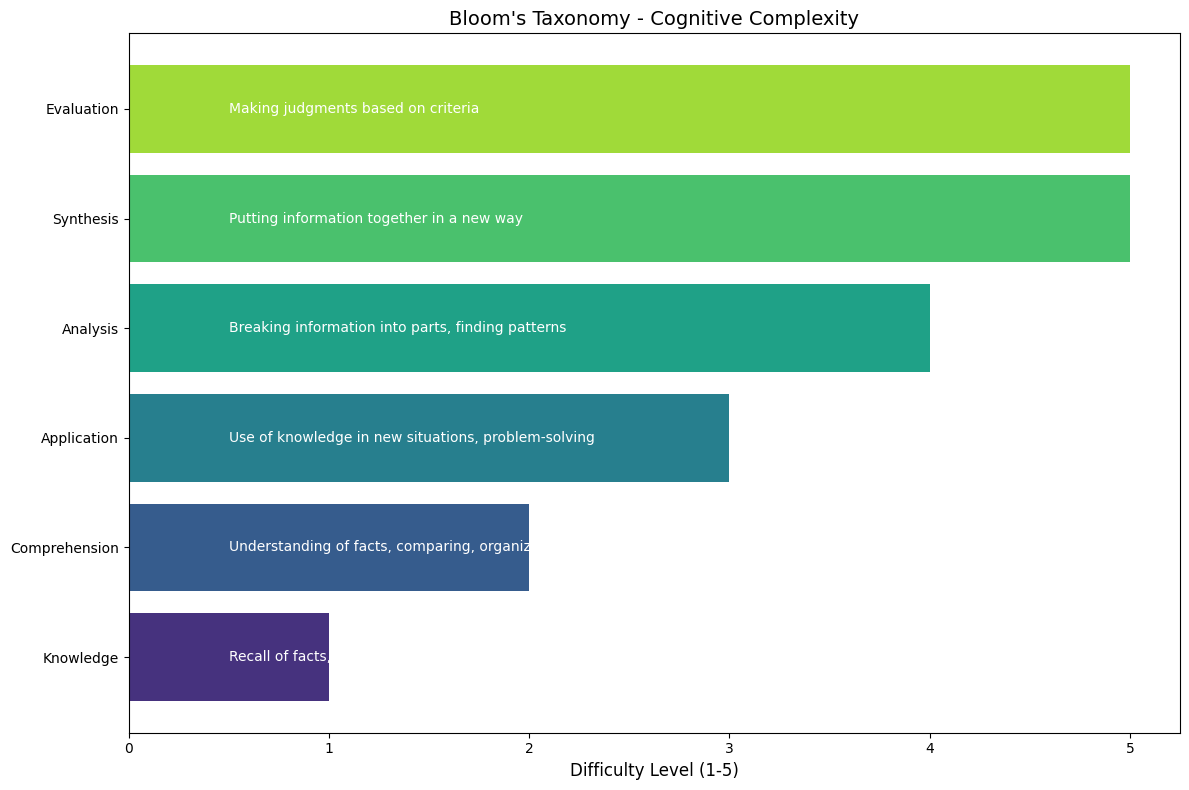


Spaced Repetition Schedule:


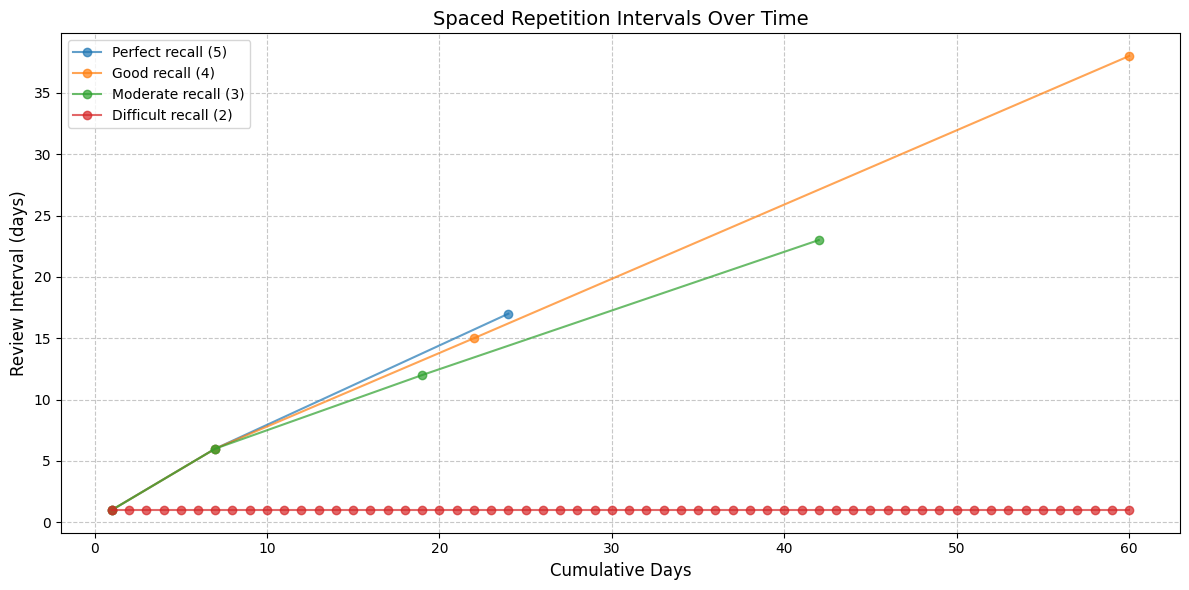


Adding sample content...
Error extracting text from PDF: EOF marker not found

Starting a sample quiz...
Found 0 due flashcards
Generating 3 new flashcards...
No relevant contexts found. Please add some learning materials first.
Generated 0 new flashcards
No flashcards available for quiz. Adding sample flashcards...
Added 3 sample flashcards

Question 1/3:
Topic: Learning Techniques, Difficulty: 1, Bloom's Level: knowledge

What is spaced repetition?

Press Enter to see the answer...

Answer:
Spaced repetition is a learning technique that involves reviewing information at increasing intervals over time to improve long-term retention.

Rate your answer quality (0-5):
0: Complete blackout
1: Incorrect answer, but recognized correct one
2: Incorrect answer, but correct seemed familiar
3: Correct answer with difficulty
4: Correct answer after hesitation
5: Perfect answer
Your rating: 0

Question 2/3:
Topic: Machine Learning, Difficulty: 2, Bloom's Level: comprehension

Compare machine lea

In [13]:
# Initialize the question generator
question_generator = LocalQuestionGenerator(vector_db, llm)

# Initialize the quiz system
quiz_system = QuizSystem(vector_db, question_generator)

# Display Bloom's Taxonomy
print("Bloom's Taxonomy Overview:")
BloomsTaxonomy.visualize_taxonomy()

# Display spaced repetition schedule
print("\nSpaced Repetition Schedule:")
SM2Algorithm.visualize_schedule(days=60)

# Add sample content if needed
print("\nAdding sample content...")
sample_text = """
Machine learning is a field of study that gives computers the ability to learn without being explicitly programmed.
It focuses on developing algorithms that can learn from and make predictions or decisions based on data.
Some common machine learning algorithms include linear regression, decision trees, support vector machines, and neural networks.

Neural networks are a set of algorithms inspired by the structure of the human brain. They consist of layers of interconnected nodes,
or "neurons," that process information. Deep learning involves neural networks with many layers, known as deep neural networks.
"""

doc_processor.process_document(
    file_path=None,
    file_content=sample_text.encode('utf-8'),
    title="Machine Learning Basics",
    topic="Machine Learning"
)

# Run a sample quiz with the local system
print("\nStarting a sample quiz...")
quiz_system.start_quiz(topic="Machine Learning", difficulty=2, num_questions=3)

# Provide option to upload PDFs
print("\nWould you like to upload your own PDF documents? (yes/no)")
if input().lower() in ['yes', 'y']:
    uploaded_materials = upload_and_process_pdf()

    # Run a quiz on the uploaded content
    print("\nRunning a quiz on your uploaded content...")
    quiz_system.start_quiz(num_questions=3)

##Add OCR and Computer Vision Libraries

In [14]:
# Install necessary packages for OCR and image processing
!pip install -q pytesseract opencv-python matplotlib pillow transformers timm

import cv2
import pytesseract
import matplotlib.pyplot as plt
from PIL import Image
import io
from transformers import pipeline, AutoFeatureExtractor, AutoModelForImageClassification
from google.colab import files

##OCR and Image Analysis Class

In [15]:
class MultiModalProcessor:
    """
    Process images, charts, and tables for question generation
    """
    def __init__(self, question_generator):
        self.question_generator = question_generator

        # Set up Tesseract path (for Google Colab)
        !apt-get install -qq tesseract-ocr
        pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

        # Set up image captioning model
        try:
            self.image_captioner = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")
            self.caption_available = True
        except:
            print("Image captioning model not available, will use basic OCR only")
            self.caption_available = False

        # Load a simple image classifier for content type detection
        try:
            self.classifier = pipeline("image-classification", model="google/vit-base-patch16-224")
            self.classifier_available = True
        except:
            print("Image classifier not available, will use basic detection")
            self.classifier_available = False

    def process_image(self, image_path=None, image_content=None):
        """Process an image file or content and extract information"""
        # Load the image
        if image_content:
            # Handle bytes content
            image = Image.open(io.BytesIO(image_content))
            img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        else:
            # Load from path
            img_cv = cv2.imread(image_path)
            image = Image.open(image_path)

        # Analyze the image to determine content type
        content_type = self._detect_content_type(image, img_cv)
        print(f"Detected content type: {content_type}")

        # Extract text with OCR
        ocr_text = pytesseract.image_to_string(image)

        # Get image caption if available
        caption = ""
        if self.caption_available:
            try:
                caption_result = self.image_captioner(image)
                caption = caption_result[0]['generated_text']
                print(f"Image caption: {caption}")
            except Exception as e:
                print(f"Error generating caption: {e}")

        # Process based on content type
        if content_type == "chart" or content_type == "graph":
            return self._process_chart(image, img_cv, ocr_text, caption)
        elif content_type == "table":
            return self._process_table(image, img_cv, ocr_text)
        else:
            return self._process_general_image(image, ocr_text, caption)

    def _detect_content_type(self, image, img_cv):
        """Detect if the image contains a chart, table, or other content"""
        # Basic heuristic approach for chart detection

        # 1. Look for grid lines (common in charts and tables)
        gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

        # Count horizontal and vertical lines
        h_lines = 0
        v_lines = 0
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                if abs(y2 - y1) < 10:  # Horizontal line
                    h_lines += 1
                if abs(x2 - x1) < 10:  # Vertical line
                    v_lines += 1

        # 2. Use classifier if available
        if self.classifier_available:
            try:
                result = self.classifier(image)
                for item in result:
                    label = item['label'].lower()
                    if 'chart' in label or 'graph' in label or 'plot' in label:
                        return "chart"
                    if 'table' in label or 'grid' in label:
                        return "table"
            except:
                pass

        # 3. Make decision based on heuristics
        if h_lines >= 5 and v_lines >= 5:
            # Likely a table structure
            return "table"
        elif (h_lines >= 3 or v_lines >= 3) and "chart" in str(pytesseract.image_to_string(image)).lower():
            # Likely a chart
            return "chart"
        elif (h_lines >= 3 or v_lines >= 3) and any(x in str(pytesseract.image_to_string(image)).lower() for x in ["graph", "axis", "trend", "plot"]):
            # Likely a graph
            return "graph"
        else:
            # General image
            return "image"

    def _process_chart(self, image, img_cv, ocr_text, caption):
        """Process chart/graph images and generate questions"""
        # Extract axis information if possible
        x_axis = ""
        y_axis = ""
        title = ""

        # Find axis labels through OCR positioning
        lines = ocr_text.split('\n')
        if len(lines) > 3:
            # Simple heuristic: title often at top, x-axis at bottom, y-axis on left
            title = lines[0]
            x_axis = lines[-2]
            for line in lines:
                if line and line not in [title, x_axis]:
                    y_axis = line
                    break

        # Combine information for question generation
        context = f"""
Chart Information:
Title: {title if title else 'Unknown'}
X-axis: {x_axis if x_axis else 'Unknown'}
Y-axis: {y_axis if y_axis else 'Unknown'}
Caption: {caption}
OCR Text: {ocr_text}

This image contains a chart or graph. The chart shows a relationship between {x_axis if x_axis else 'values'} and {y_axis if y_axis else 'measurements'}.
"""

        # Generate questions about the chart
        questions = self._generate_questions_from_context(context, "chart")

        # Create a report
        report = {
            "content_type": "chart",
            "ocr_text": ocr_text,
            "caption": caption,
            "title": title,
            "x_axis": x_axis,
            "y_axis": y_axis,
            "questions": questions
        }

        return report

    def _process_table(self, image, img_cv, ocr_text):
        """Process table images and extract structured data"""
        # Try to reconstruct table structure
        lines = ocr_text.split('\n')
        table_data = []

        # Simple parsing of table structure based on spaces
        for line in lines:
            if line.strip():
                cells = [cell.strip() for cell in line.split('  ') if cell.strip()]
                if cells:
                    table_data.append(cells)

        # Try to identify headers (first row often contains headers)
        headers = table_data[0] if table_data else []

        # Build context for question generation
        context = f"""
Table Information:
Headers: {', '.join(headers) if headers else 'Unknown'}
Rows: {len(table_data) - 1 if len(table_data) > 1 else 0}
OCR Text: {ocr_text}

This image contains a table with the following data:
{ocr_text}
"""

        # Generate questions about the table
        questions = self._generate_questions_from_context(context, "table")

        # Create a report
        report = {
            "content_type": "table",
            "ocr_text": ocr_text,
            "headers": headers,
            "table_data": table_data,
            "questions": questions
        }

        return report

    def _process_general_image(self, image, ocr_text, caption):
        """Process general images"""
        # Build context for question generation
        context = f"""
Image Information:
Caption: {caption}
OCR Text: {ocr_text}

This is a general image. {caption}
"""

        # Generate questions about the image
        questions = self._generate_questions_from_context(context, "image")

        # Create a report
        report = {
            "content_type": "image",
            "ocr_text": ocr_text,
            "caption": caption,
            "questions": questions
        }

        return report

    def _generate_questions_from_context(self, context, content_type):
        """Generate questions based on the extracted content"""
        # Determine appropriate Bloom's level based on content type
        if content_type == "chart" or content_type == "graph":
            # Charts often require analysis or interpretation
            bloom_level = "analysis"
            difficulty = 4
        elif content_type == "table":
            # Tables might be more about comprehension or application
            bloom_level = "application"
            difficulty = 3
        else:
            # Regular images might be knowledge or comprehension
            bloom_level = "comprehension"
            difficulty = 2

        # Create a prompt focused on the visual content
        prompt = f"""
Create 3 educational questions based on this {content_type}:

CONTENT INFORMATION:
{context}

INSTRUCTIONS:
- Focus on what can be learned from the {content_type}
- For charts/graphs, ask about trends, relationships, or conclusions
- For tables, ask about data relationships or calculations
- For images, ask about what is shown or its significance
- Format: Q1: [question] A1: [answer]

QUESTIONS AND ANSWERS:
"""

        try:
            # Generate text with the local model
            response = self.question_generator.llm.invoke(prompt)

            # Parse the response to extract questions and answers
            qa_pairs = self.question_generator._parse_questions_answers(response)

            # Create flashcards from questions
            flashcards = []
            for q, a in qa_pairs:
                if len(q) > 10 and len(a) > 10:  # Basic validation
                    flashcard = {
                        "question": q,
                        "answer": a,
                        "topic": content_type.capitalize(),
                        "difficulty": difficulty,
                        "bloomLevel": bloom_level,
                        "easinessFactor": 2.5,
                        "interval": 0,
                        "repetitions": 0,
                        "nextReviewDate": datetime.now(),
                        "lastReviewDate": None
                    }

                    # Add to database
                    flashcard_id = self.question_generator.db.add_flashcard(flashcard)
                    flashcards.append({
                        "id": flashcard_id,
                        **flashcard
                    })

            return flashcards

        except Exception as e:
            print(f"Error generating questions: {e}")
            return []

    def upload_and_process_image(self):
        """Upload and process an image in Google Colab"""
        print("Please upload an image file (chart, graph, table, etc.)...")
        uploaded = files.upload()

        for filename, content in uploaded.items():
            print(f"Processing {filename}...")
            report = self.process_image(image_content=content)

            # Display the results
            print(f"\nDetected content type: {report['content_type']}")

            if 'caption' in report:
                print(f"Caption: {report['caption']}")

            print("\nExtracted text:")
            print(report['ocr_text'][:500] + "..." if len(report['ocr_text']) > 500 else report['ocr_text'])

            print("\nGenerated questions:")
            for i, q in enumerate(report['questions']):
                print(f"\nQuestion {i+1}:")
                print(f"Q: {q['question']}")
                print(f"A: {q['answer']}")
                print(f"Level: {q['bloomLevel']} (Difficulty: {q['difficulty']})")

            return report

##Update the main system to include multi-modal features

In [16]:
# Initialize the multi-modal processor
multi_modal_processor = MultiModalProcessor(question_generator)

# Add multi-modal quiz function to the quiz system
def add_to_quiz_system(quiz_system):
    """Add multi-modal question methods to the quiz system"""

    def start_image_quiz(self, num_questions=3):
        """Start a quiz with questions from uploaded images"""
        # Get existing image-based flashcards
        image_cards = [fc for fc in self.db.flashcards
                      if fc.get("topic") in ["Chart", "Graph", "Table", "Image"]]

        # If we need more cards, prompt for image upload
        if len(image_cards) < num_questions:
            print("Please upload images to generate more questions.")
            multi_modal_processor.upload_and_process_image()

            # Get updated list of image cards
            image_cards = [fc for fc in self.db.flashcards
                          if fc.get("topic") in ["Chart", "Graph", "Table", "Image"]]

        # Use available cards
        quiz_cards = image_cards[:num_questions]
        random.shuffle(quiz_cards)

        # Run quiz
        self._run_quiz_with_cards(quiz_cards)

    # Add the method to the quiz system
    quiz_system.start_image_quiz = start_image_quiz.__get__(quiz_system, type(quiz_system))

    # Add helper method to run quiz with cards
    def _run_quiz_with_cards(self, quiz_cards):
        """Run a quiz with specific cards"""
        if not quiz_cards:
            print("No flashcards available for quiz.")
            return 0

        correct_count = 0
        for i, card in enumerate(quiz_cards):
            print(f"\nQuestion {i+1}/{len(quiz_cards)}:")
            print(f"Topic: {card['topic']}, Difficulty: {card['difficulty']}, Bloom's Level: {card['bloomLevel']}")
            print(f"\n{card['question']}")

            input("\nPress Enter to see the answer...")

            print("\nAnswer:")
            print(card['answer'])

            # Get quality rating
            quality = int(input("\nRate your answer quality (0-5):\n"
                              "0: Complete blackout\n"
                              "1: Incorrect answer, but recognized correct one\n"
                              "2: Incorrect answer, but correct seemed familiar\n"
                              "3: Correct answer with difficulty\n"
                              "4: Correct answer after hesitation\n"
                              "5: Perfect answer\n"
                              "Your rating: "))

            # Update flashcard based on quality rating
            if quality >= 3:
                correct_count += 1

            # Calculate next review date using SM2 algorithm
            new_easiness, new_interval, new_repetitions, next_review_date = SM2Algorithm.calculate_next_review(
                quality,
                card.get("easinessFactor", 2.5),
                card.get("interval", 0),
                card.get("repetitions", 0)
            )

            # Update card in database
            self.db.update_flashcard(card["id"], {
                "easinessFactor": new_easiness,
                "interval": new_interval,
                "repetitions": new_repetitions,
                "nextReviewDate": next_review_date,
                "lastReviewDate": datetime.now()
            })

        # Show results
        score = (correct_count / len(quiz_cards)) * 100
        print(f"\nQuiz completed! Score: {score:.1f}% ({correct_count}/{len(quiz_cards)})")
        return score

    # Add the helper method
    quiz_system._run_quiz_with_cards = _run_quiz_with_cards.__get__(quiz_system, type(quiz_system))

# Update the quiz system with multi-modal capabilities
add_to_quiz_system(quiz_system)

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.50.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cuda:0


## Run the Complete System with All Features

In [17]:
# Run the complete system
print("\n=== LLM-Based Learning Assistant with All Features ===\n")

# Option menu
def show_menu():
    print("\nLearning Assistant Menu:")
    print("1. Upload and process text documents (PDFs)")
    print("2. Upload and process images (charts, tables, graphs)")
    print("3. Take a text-based quiz")
    print("4. Take an image-based quiz")
    print("5. Visualize Bloom's Taxonomy")
    print("6. Visualize Spaced Repetition System")
    print("7. Exit")
    return input("\nEnter your choice (1-7): ")

# Main loop
while True:
    choice = show_menu()

    if choice == '1':
        # Upload and process text documents
        uploaded_materials = upload_and_process_pdf()

    elif choice == '2':
        # Upload and process images
        multi_modal_processor.upload_and_process_image()

    elif choice == '3':
        # Take a text-based quiz
        print("\nStarting a text-based quiz...")
        topic = input("Enter a topic (or leave blank for all topics): ")
        difficulty = input("Enter difficulty level (1-5, or leave blank for default): ")
        difficulty = int(difficulty) if difficulty.isdigit() else 2
        quiz_system.start_quiz(topic=topic if topic else None,
                               difficulty=difficulty,
                               num_questions=3)

    elif choice == '4':
        # Take an image-based quiz
        print("\nStarting an image-based quiz...")
        quiz_system.start_image_quiz(num_questions=3)

    elif choice == '5':
        # Visualize Bloom's Taxonomy
        print("\nBloom's Taxonomy Visualization:")
        BloomsTaxonomy.visualize_taxonomy()

    elif choice == '6':
        # Visualize Spaced Repetition System
        print("\nSpaced Repetition Schedule Visualization:")
        days = input("Enter number of days to simulate (default 60): ")
        days = int(days) if days.isdigit() else 60
        SM2Algorithm.visualize_schedule(days=days)

    elif choice == '7':
        # Exit
        print("\nThank you for using the Learning Assistant!")
        break

    else:
        print("\nInvalid choice. Please try again.")


=== LLM-Based Learning Assistant with All Features ===


Learning Assistant Menu:
1. Upload and process text documents (PDFs)
2. Upload and process images (charts, tables, graphs)
3. Take a text-based quiz
4. Take an image-based quiz
5. Visualize Bloom's Taxonomy
6. Visualize Spaced Repetition System
7. Exit

Enter your choice (1-7): 7

Thank you for using the Learning Assistant!
